<a href="https://colab.research.google.com/github/Andrew11Morozov/yan.pract/blob/main/morozov_ab_retail_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Учебный проект - 2. Изучение пользовательского поведения мобильного приложения по продаже продуктов питания.

Стартап продаёт продукты питания. Задача учебного проекта - разобраться, как ведут себя пользователи мобильного приложения стартапа. Кроме того, изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах. Выяснить на каких именно шагах останавливаются пользователи.
После этого необходимо исследовать результаты A/A/B-эксперимента: Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователи разбиты на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить, какой шрифт лучше.

Описание данных.

Каждая запись в логе — это действие пользователя, или событие. 

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 
        246 и 247 — контрольные группы, 
        248 — экспериментальная.


## Загрузка и подготовка данных к анализу

Загружаем данные CSV-файлов в переменные.

Путь к файлу:

https://code.s3.yandex.net/datasets/logs_exp.csv

Изучаем данные и выполняем предобработку. 

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
#register_matplotlib_converters()
import scipy.stats as stats
import math
import plotly.express as px
from IPython.display import Image

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep='\t') # загружаю данные из logs_exp.csv  - журнал событий

In [3]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Для удобства дальнейшей работы добавим столбец Даты-времени события, а также только Даты. Эти столбцы можно получить из столбца **EventTimestamp**.

Для получения даты-времени необходимо изменить формат колонки **EventTimestamp** с формата `Timestamp` на привычный `datetime64[ns]`. Сделаем это в два этапа (двумя строчками кода): 

Применим lambda-функцию к каждой строчке колонки `EventTimestamp` и поменяем тип данных для всей колонки с `object` на `datetime64[ns]`

In [5]:
df['time'] = df['EventTimestamp'].map(
    lambda x: dt.datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S')
)

In [6]:
df['time'] = pd.to_datetime(df['time'])
#df.info() # check
df.head() # check

,EventName,DeviceIDHash,EventTimestamp,ExpId,time
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


Для формирования столбца даты отсечем время от данных колонки `time` - так же применим lambda-функцию к каждой строчки колонки `time`.

In [7]:
df['date'] = df['time'].apply(lambda x: x.strftime('%Y-%m-%d'))
df['date'] = pd.to_datetime(df['date'])
df.info() # check
df.head() # check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   EventName       244126 non-null  object        
 1   DeviceIDHash    244126 non-null  int64         
 2   EventTimestamp  244126 non-null  int64         
 3   ExpId           244126 non-null  int64         
 4   time            244126 non-null  datetime64[ns]
 5   date            244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId,time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Переименуем колонки в соответствии с правилами PYTHON: 

In [8]:
df = df.rename(columns={'EventName': 'event_name',
                        'DeviceIDHash': 'id',
                        'EventTimestamp': 'event_ts', 
                        'ExpId': 'exp_id'})

In [9]:
df.head() # check

,event_name,id,event_ts,exp_id,time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [10]:
df.info() # check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   id          244126 non-null  int64         
 2   event_ts    244126 non-null  int64         
 3   exp_id      244126 non-null  int64         
 4   time        244126 non-null  datetime64[ns]
 5   date        244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


### Выводы по разделу

Данные готовы для изучения:

- Названия столбцов переименованы в соответствии с требованиями PYTHON;
- Типы данных соответствуют названиям колонок;
- Пропусков нет.


Теперь описание подготовленных данных выглядит так:

Каждая запись в логе — это действие пользователя, или событие.

- event_name — название события;
- id — уникальный идентификатор пользователя;
- event_ts — время события (Timestamp);
- exp_id — номер эксперимента:

  246 и 247 — контрольные группы,\
  248 — экспериментальная.
  

- time - дата и время эксперимента;
- date - дата эксперимента.

## Изучение и проверка данных

Проверяем дубликаты:

In [11]:
df[df.duplicated ()]

,event_name,id,event_ts,exp_id,time,date
453,MainScreenAppear,5613408041324010552,1564474784,248,2019-07-30 08:19:44,2019-07-30
2350,CartScreenAppear,1694940645335807244,1564609899,248,2019-07-31 21:51:39,2019-07-31
3573,MainScreenAppear,434103746454591587,1564628377,248,2019-08-01 02:59:37,2019-08-01
4076,MainScreenAppear,3761373764179762633,1564631266,247,2019-08-01 03:47:46,2019-08-01
4803,MainScreenAppear,2835328739789306622,1564634641,248,2019-08-01 04:44:01,2019-08-01
...,...,...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,1565206004,247,2019-08-07 19:26:44,2019-08-07
242332,PaymentScreenSuccessful,4718002964983105693,1565206005,247,2019-08-07 19:26:45,2019-08-07
242360,PaymentScreenSuccessful,2382591782303281935,1565206049,246,2019-08-07 19:27:29,2019-08-07
242362,CartScreenAppear,2382591782303281935,1565206049,246,2019-08-07 19:27:29,2019-08-07


В 244126 строках событий выявлено 413 строчек полностью повторяющих уже существующие во всех столбцах DataFrame. Удаляем дубликаты:

In [12]:
df = df.drop_duplicates()

In [13]:
df.shape[0]

243713

После удаления дубликатов в логе осталось ***243713*** оригинальных событий.

Проверим количество оригинальных пользователей (`id`)

In [14]:
df['id'].unique().shape[0]

7551

Оригинальных пользователей (id) - ***7551*** человек.

Узнаем сколько событий в среднем на одного пользователя:

In [15]:
average_event_to_user = df.shape[0] / df['id'].unique().shape[0]
average_event_to_user

32.27559263673685

В среднем каждый пользователь "сгенерировал" ***32*** события.

Посмотрим в какой период проводились эксперименты. Найдем крайние даты наблюдений (экспериментов) попавшие в этот  DataFrame.

In [16]:
df['time'].min()

Timestamp('2019-07-25 04:43:36')

In [17]:
df['time'].max()

Timestamp('2019-08-07 21:15:17')

Итак, все наблюдения проводились в период с ***25 июля 2019 года по 07 августа 2019 года***. 

Посмотрим как распредедены данные между этими датами:

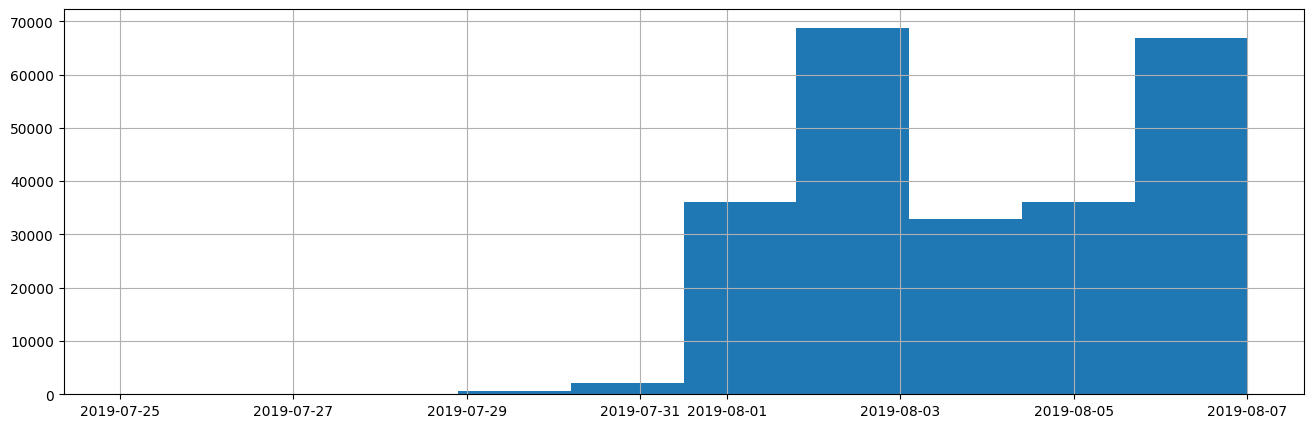

In [18]:
plt.figure(figsize=(16, 5))
df['date'].hist();

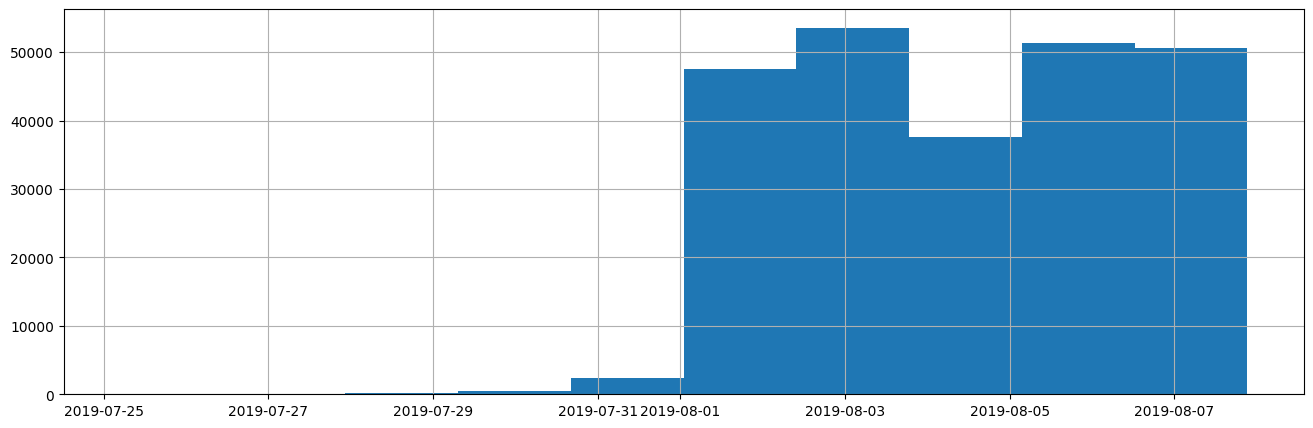

In [19]:
plt.figure(figsize=(16, 5))
df['time'].hist();

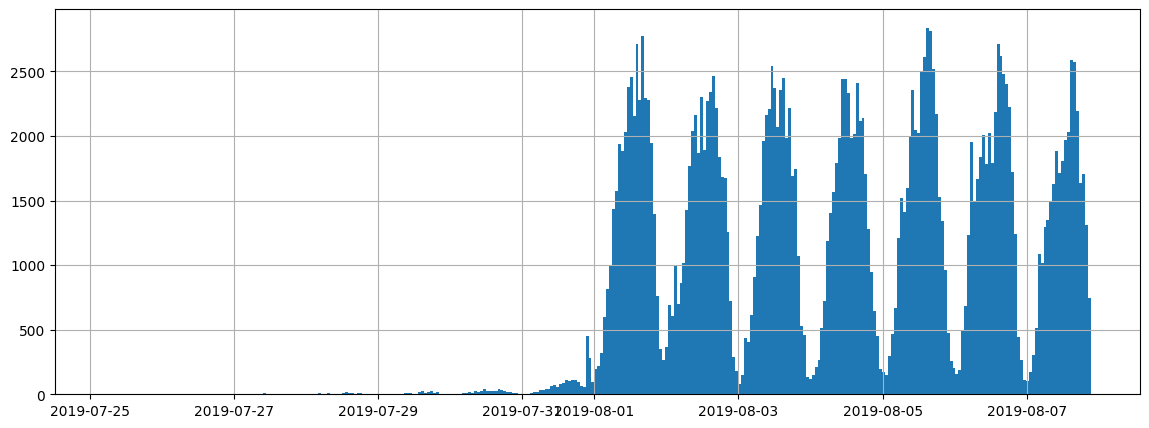

In [20]:
# код 
df['time'].hist(bins=14*24, figsize=(14, 5));

На гистограмме видно, что в первую неделю наблюдений данных по событиям значительно меньше, чем во вторую неделю наблюдний (проведения эксперимента).
Возможно в первую неделю попали данные "еще не начавшегося эксперимента" или данные неверно выгруженные из базы. Так как уточнить в рамках учебного проекта не у кого, принимаем решение отбросить данные до 01 августа 2019 года, и использовать для дальнейшего анализа только данные с ***01 августа 2019 года по 07 августа 2019 года***

Для подтверждения правильности принятого решения посмотрим сколько и какого качества данные мы отбросили.

Проверяем, сколько отбросили:

In [21]:
t = df.query('date < "2019-08-01"')['exp_id'].shape[0]
print ('До 01 августа 2019 года в эксперименте было ', t, ' событий, что составляет ', round(t/df.shape[0]*100, 2), 'процента.')

До 01 августа 2019 года в эксперименте было  2826  событий, что составляет  1.16 процента.


Посмотрим, сколько пользователей мы потеряли:

In [22]:
tu_aug = df['id'].unique().shape[0]
t1 = df.query('date >= "2019-08-01"')['id'].unique().shape[0]
print ('До 01 августа 2019 года в эксперименте отметились ', tu_aug - t1, ' уникальных пользователей, что составляет ', round((tu_aug - t1)/df['id'].unique().shape[0]*100, 2), 'процента.')

До 01 августа 2019 года в эксперименте отметились  17  уникальных пользователей, что составляет  0.23 процента.


Распределение между экспериментами в отброшенных данных равноменное:

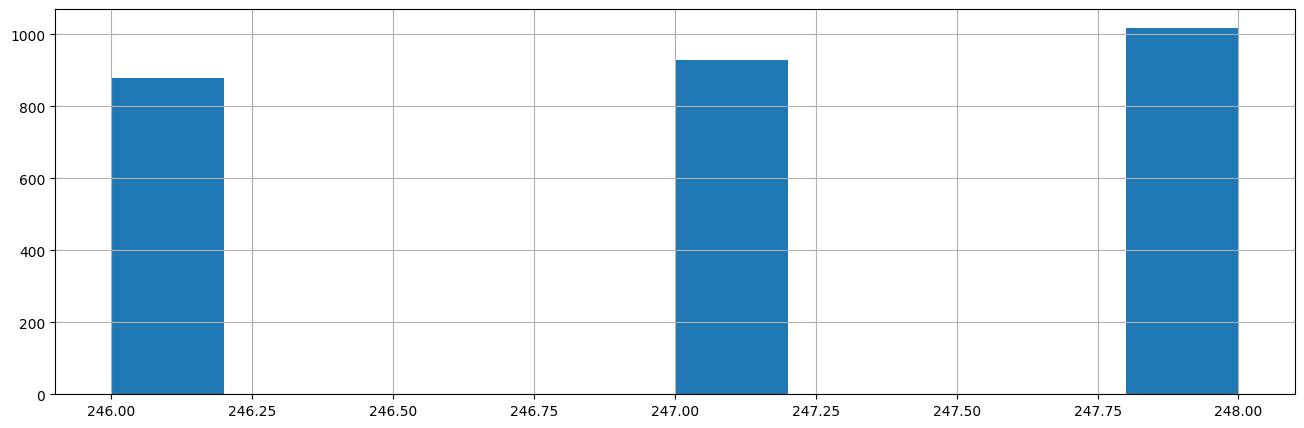

In [23]:
t = df.query('date < "2019-08-01"')['exp_id']#.unique()
plt.figure(figsize=(16, 5))
t.hist();

Чуть выше 1000 событий в экспериментальной группе, чуть меньше 1000 в обоих контрольных группах.

Распределение между названиями событий (event_name) в отброшеннх данных - присутствуют все имена (названия).

'Массив уникальных названий событий - '

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

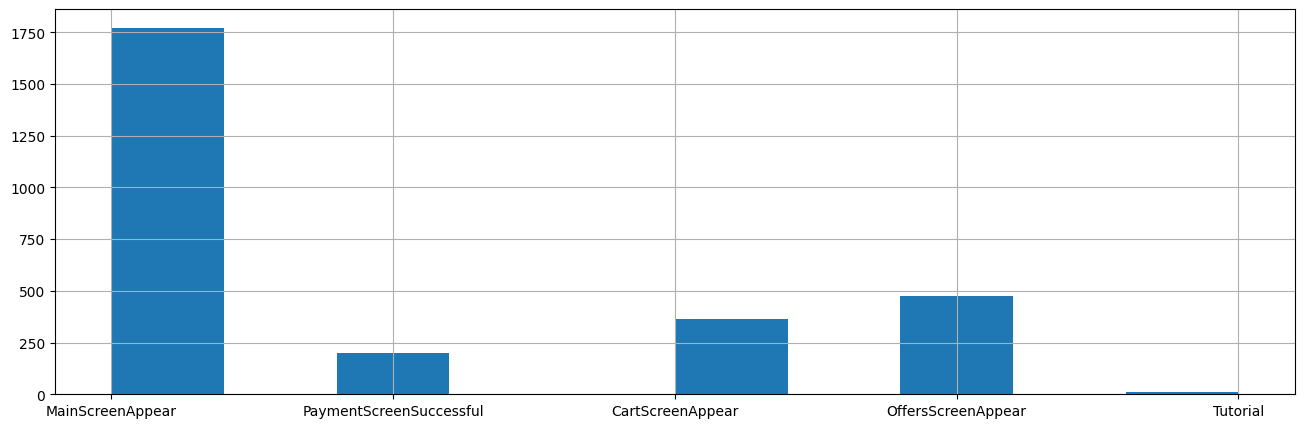

In [24]:
t = df.query('date < "2019-08-01"')['event_name']
display('Массив уникальных названий событий - ', df.query('date < "2019-08-01"')['event_name'].unique());
plt.figure(figsize=(16, 5))
t.hist();

Распределение между пользователями (id) в отброшеннх данных тоже достаточно равномерно. То есть выделить какую группу пользователей или одного пользователя невозможно.

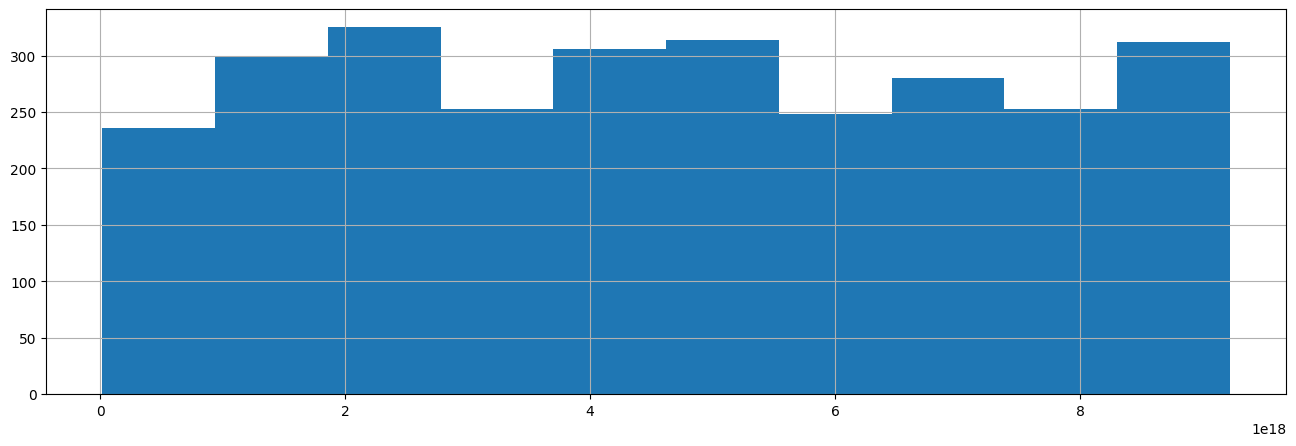

In [25]:
t = df.query('date < "2019-08-01"')['id']
#display(df.query('date < "2019-08-01"')['id'].unique());
#display(df.query('date < "2019-08-01"')['id'].shape[0]);
plt.figure(figsize=(16, 5))
t.hist();


На основании вышеизложенного безжалостно отбрасываем малоинформативные данные за первую неделю:

In [26]:
df = df.query('date >= "2019-08-01"')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  240887 non-null  object        
 1   id          240887 non-null  int64         
 2   event_ts    240887 non-null  int64         
 3   exp_id      240887 non-null  int64         
 4   time        240887 non-null  datetime64[ns]
 5   date        240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 12.9+ MB


In [27]:
df.head()

,event_name,id,event_ts,exp_id,time,date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [28]:
print('После изучения и проверки данных осталось ', df.shape[0], 'записи в  DataFrame - событий.')

После изучения и проверки данных осталось  240887 записи в  DataFrame - событий.


Проверим, насколько равномерно распределились между группами экспериментов после отбрасывания данных:

In [29]:
group_exp = df.groupby('exp_id').count()
display(group_exp)

,event_name,id,event_ts,time,date
exp_id,,,,,
246,79302,79302,79302,79302,79302
247,77022,77022,77022,77022,77022
248,84563,84563,84563,84563,84563


In [30]:
group_exp = (
    df
    .groupby('exp_id', as_index=False)
    .agg({'id': 'count'})
)
group_exp.columns = ['exp_id', 'count']
group_exp

,exp_id,count
0,246,79302
1,247,77022
2,248,84563


Напомним себе, что

- 246 и 247 — контрольные группы,
- 248 — экспериментальная.

Найдем процент отличия двух контрольных груп между собой и первой контрольной и экспериментальной в процентах:

In [31]:
t0 = group_exp[group_exp['exp_id'] == 246]['count'][0]
t1 = group_exp[group_exp['exp_id'] == 247]['count'][1]
t2 = group_exp[group_exp['exp_id'] == 248]['count'][2]
print ('Количество наблюдений (событий) в первой  контрольной группе - ', t0)
print ('Количество наблюдений (событий) во второй контрольной группе - ', t1)
print ('Количество наблюдений (событий) в  экспериментальной  группе - ', t2)
print ()
print ('Различие в событиях между первой и второй контрольной группой - ', round((t0-t1)/t0*100,2), '%')
print ('Различие в событиях между первой и экспериментальной  группой - ', round((t2-t0)/t2*100,2), '%')

Количество наблюдений (событий) в первой  контрольной группе -  79302
Количество наблюдений (событий) во второй контрольной группе -  77022
Количество наблюдений (событий) в  экспериментальной  группе -  84563

Различие в событиях между первой и второй контрольной группой -  2.88 %
Различие в событиях между первой и экспериментальной  группой -  6.22 %


Проверим сколько уникальных пользователей осталось в эксперименте в каждой группе:

In [32]:
t1 = df[df['exp_id'] == 247]['id'].unique().shape[0]
t2 = df[df['exp_id'] == 248]['id'].unique().shape[0]
t3 = df[df['exp_id'] == 248]['id'].unique().shape[0]
t0 = df['id'].unique().shape[0]

print ('Количество уникальных пользователей  в первой  контрольной группе - ', t1)
print ('Количество уникальных пользователей во второй  контрольной группе - ', t2)
print ('Количество уникальных пользователей в эксериментальной группе -     ', t3)
print ('Количество уникальных пользователей во всей выборке -               ', t0)

Количество уникальных пользователей  в первой  контрольной группе -  2513
Количество уникальных пользователей во второй  контрольной группе -  2537
Количество уникальных пользователей в эксериментальной группе -      2537
Количество уникальных пользователей во всей выборке -                7534


### Выводы по разделу 2

В разделе 2 учебного проекта проведена следующая работа и решены задачи:

- Выявлены и удалены дубликаты в данных;
- Рассмотрены и назначены (сокращены) периоды рассмотрения данных. Рассматриваем в дальнейшем данные с 01 августа 2019 года по 07 августа 2019 года;
- Проверена равноменность отброшенных данных;
- Проверена и подтверждена равномерность оставшихся данных.

## Изучение воронки событий

### Изучение распределения событий

Более внимательно изучим события присутствующие в предложенных данных

In [33]:
t= df.groupby('event_name', as_index=False).agg({'id': 'count'}) # временная переменная распределения событий по названию

t.columns = ['event_name', 'count']
t = t.sort_values(by='count', ascending=False)
t

,event_name,count
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


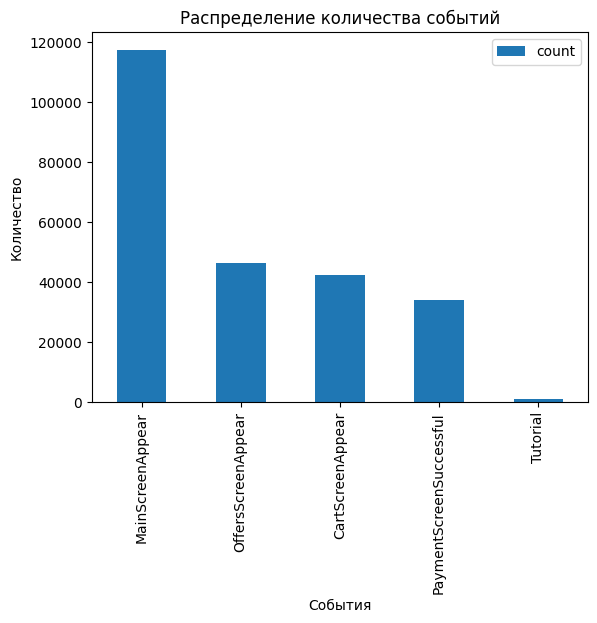

In [34]:
#plt.figure(figsize=(16, 5))
t.plot(kind='bar', x='event_name', y='count');
# Оформляем графики
plt.title('Распределение количества событий')
plt.xlabel('События')
plt.ylabel('Количество', rotation=90)
plt.legend();

Найдем долю пользоватилей, которые хоть раз совершали каждое из событий для каждого события:
(временные данные сохраним в переменной t)

In [35]:
#Число уникакльных пользователей оставшихся в эксперименте
df['id'].unique().shape[0]

7534

In [36]:
t = df.groupby(['event_name'], as_index=False).agg({'id': 'nunique'})
t.columns = ['event_name', 'count_user']
t = t.sort_values(by='count_user', ascending=False).reset_index().drop('index', axis=1)
t ['ratio'] = round (t ['count_user'] / df['id'].unique().shape[0], 5)
t

,event_name,count_user,ratio
0,MainScreenAppear,7419,0.98474
1,OffersScreenAppear,4593,0.60964
2,CartScreenAppear,3734,0.49562
3,PaymentScreenSuccessful,3539,0.46974
4,Tutorial,840,0.11149


Мы получили таблицу распределения уникальных пользователей по событиям. В таблице получилось, что первое событие "Вход на главную страницу" не получился равным единице. Видимо данные о событиях для входа этих пользователей были отброшены. Вход в приложение для 1,5% пользователей был осуществлен в период до 2019-08-01. Думаю с этим надо смириться!

### Изучение пользователей в воронке событий

Выделим уникальных пользователей совершивших каждый вид событий в отдельную переменную:

In [37]:
df.head()

,event_name,id,event_ts,exp_id,time,date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [38]:
user_MainScreenAppear = df.query('event_name == "MainScreenAppear"')['id'].unique()
print ('Количество пользователей совершивших событие MainScreenAppear - ', user_MainScreenAppear.shape[0], ' человек')
# В переменной user_MainScreenAppear храняться id уникальных пользователей совершивших событие MainScreenAppear
#                                                                                              появился_главный_экран

Количество пользователей совершивших событие MainScreenAppear -  7419  человек


In [39]:
user_MainScreenAppear = df.query('event_name == "OffersScreenAppear"')['id'].unique()
print ('Количество пользователей совершивших событие MainScreenAppear - ', user_MainScreenAppear.shape[0], ' человек')
# В переменной user_MainScreenAppear храняться id уникальных пользователей совершивших событие OffersScreenAppear
#                                                                                              на_экране_провляются_предложения       

Количество пользователей совершивших событие MainScreenAppear -  4593  человек


In [40]:
user_CartScreenAppear = df.query('event_name == "CartScreenAppear"')['id'].unique()
print ('Количество пользователей совершивших событие CartScreenAppear - ', user_CartScreenAppear.shape[0], ' человек')
# В переменной user_MainScreenAppear храняться id уникальных пользователей совершивших событие CartScreenAppear
#                                                                                              появился_экран_корзины

Количество пользователей совершивших событие CartScreenAppear -  3734  человек


In [41]:
user_PaymentScreenSuccessful = df.query('event_name == "PaymentScreenSuccessful"')['id'].unique()
print ('Количество пользователей совершивших событие PaymentScreenSuccessful - ', user_PaymentScreenSuccessful.shape[0], ' человек')
# В переменной user_PaymentScreenSuccessful храняться id уникальных пользователей совершивших событие PaymentScreenSuccessful
#                                                                                              экран_успешного_платежа

Количество пользователей совершивших событие PaymentScreenSuccessful -  3539  человек


In [42]:
user_Tutorial = df.query('event_name == "Tutorial"')['id'].unique()
print ('Количество пользователей совершивших событие Tutorial - ', user_Tutorial.shape[0], ' человек')
# В переменной user_Tutorial храняться id уникальных пользователей совершивших событие Tutorial
#                                                                                      руководство

Количество пользователей совершивших событие Tutorial -  840  человек


Такой же результат можно получить таблицей:

In [43]:
df_groupe = df.groupby(['event_name','id'])['event_ts'].count().reset_index()
df_groupe = df_groupe.groupby(['event_name'])['event_ts'].count().reset_index()
df_groupe = df_groupe.sort_values(by='event_ts', ascending=False)
df_groupe.columns = ['event_name', 'count']

In [44]:
df_groupe # содержит количества уникальных пользователей совершивших каждый вид событий.

,event_name,count
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [45]:
t # - временная переменная распределения событий по названиям
t= df.groupby('event_name', as_index=False).agg({'id': 'count'}) # временная переменная распределения событий по названию
t.columns = ['event_name', 'count']
t = t.sort_values(by='count', ascending=False)
t

,event_name,count
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


In [46]:
t = t.sort_values(by='count', ascending=False)
t # содержит количество событий по видам событий (переменная служебная временная)

,event_name,count
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


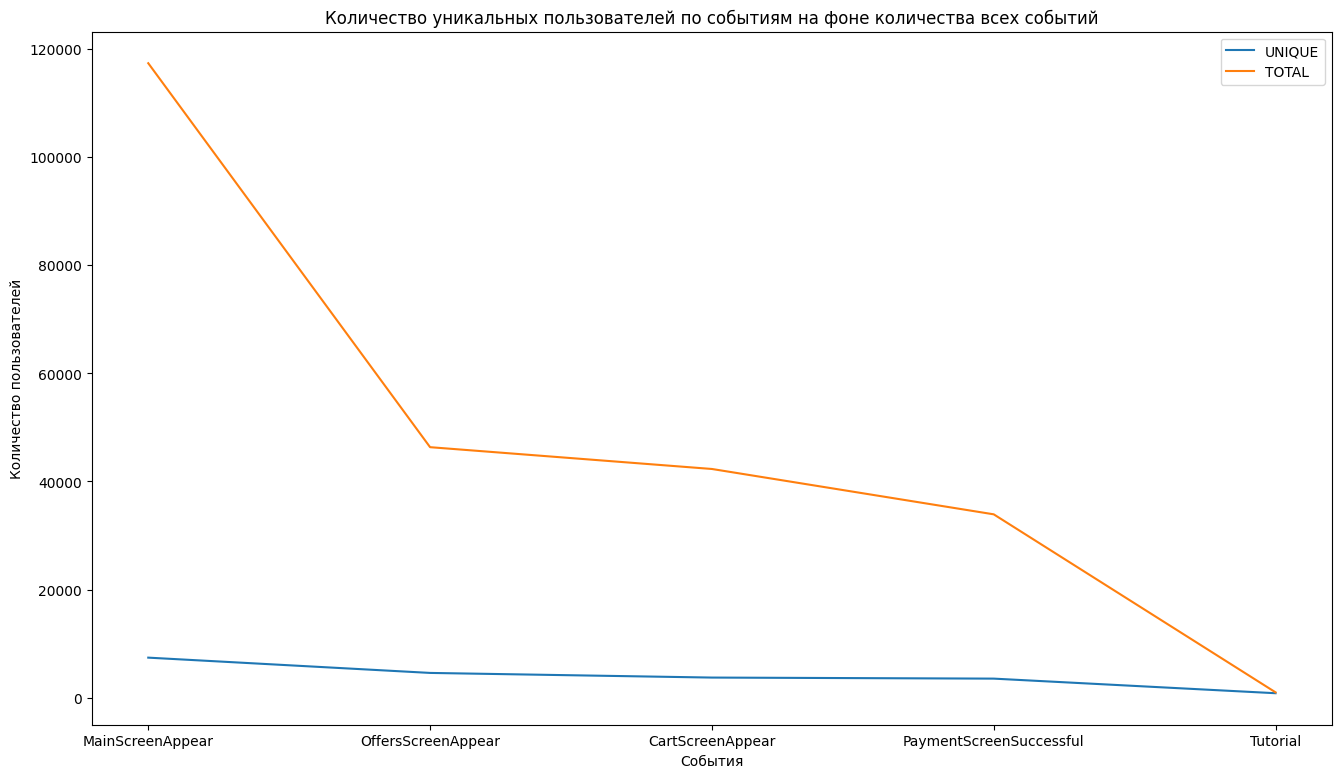

In [47]:
# Строим график для визуализации по уникальным пользователям
plt.figure(figsize=(16, 9))
plt.plot(df_groupe['event_name'], df_groupe['count'], label='UNIQUE')

# Строим график по событиям
plt.plot(t['event_name'], t['count'], label='TOTAL')

# Оформляем графики
plt.title('Количество уникальных пользователей по событиям на фоне количества всех событий')
plt.xlabel('События')
plt.ylabel('Количество пользователей', rotation=90);
plt.legend();

Чтобы лучше рассмотреть воронку событий разместим график на отдельном листе:

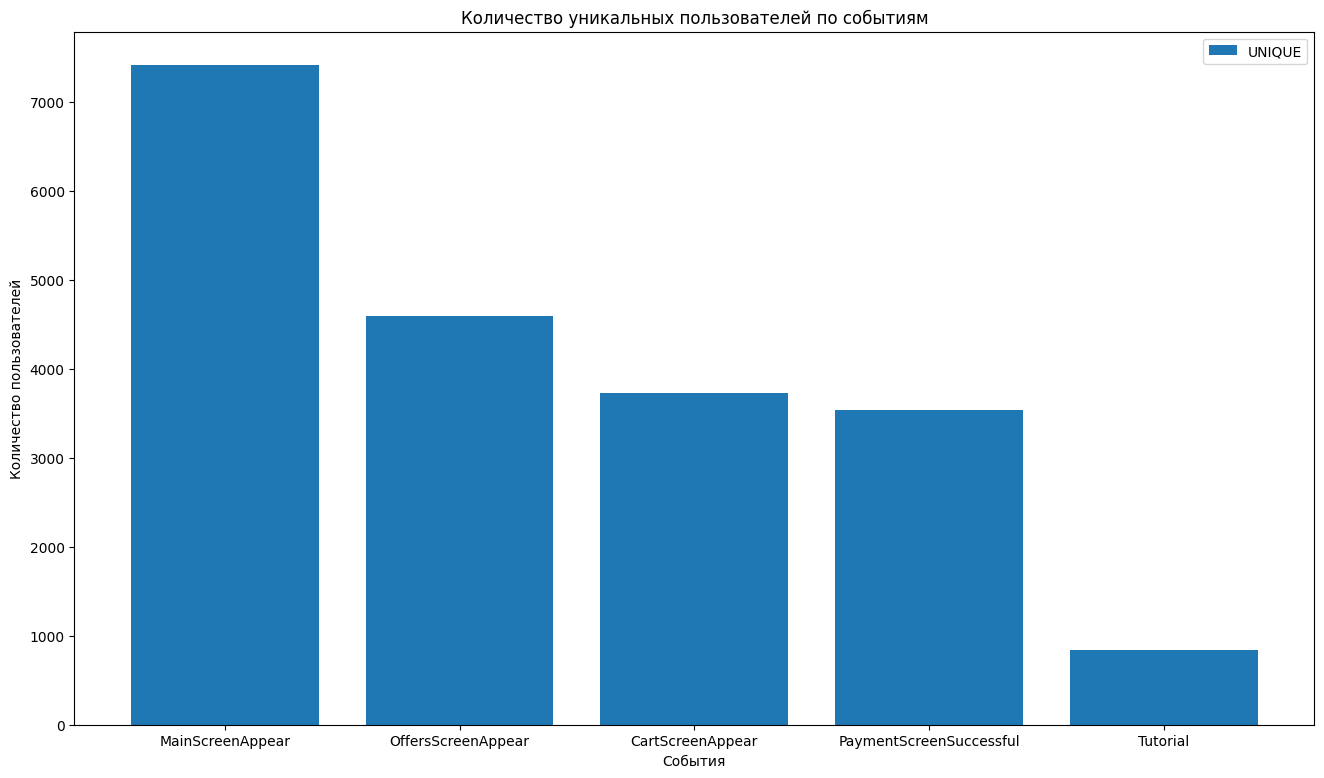

In [48]:
# Строим график для визуализации по уникальным пользователям
plt.figure(figsize=(16, 9))
plt.bar(df_groupe['event_name'], df_groupe['count'], label='UNIQUE')

# Оформляем графики
plt.title('Количество уникальных пользователей по событиям')
plt.xlabel('События')
plt.ylabel('Количество пользователей', rotation=90);
plt.legend();

### Выстраивание последовательности событий

Ещё раз рассмотрим название событий и облечем в писменную форму наши предположения по последовательности событий.

***Появился главный экран*** - `MainScreenAppear` - видимо это события первого входа на сайт магазина после перехода из командной строки браузера или перехода из поисковика. С моей точки зрения это первое событие, которое прходят все пользователи решившие посетить сайт этого магазина.

***Предложения появляются на экране*** - `OffersScreenAppear` - скорее всего это событие перехода посетителя магазина в каталог, когда посетитель начинает видеть витрину товаров и пролистовать на этой странице, нажимая на кнопку "ПОЛОЖИТЬ В КОРЗИНУ".

***Появится экран корзины*** - `CartScreenAppear` - по моей логике, это следующий шаг продвижения посетителя сайта по страницам сайта магазина. Нажав на предыдущей странице кнопку "ПЕРЕЙТИ В КОРЗИНУ" посетитель переходит на этот уровень и попадает на экран корзины, тем самым создавая событие.

***Платежные экраны успешны*** - `PaymentScreenSuccessful` предположительно последний этап воронки - успешная оплата выбранного и положенного в корзину товара. 

***Руководство*** - `Tutorial` - еще одно событие, предложенное в данных, но, по всей видимости, не связанное с воронкой событий. Предпологаю, что переход на страницу "Руководства пользователя" возможен с любого места сайта, если у пользователя возникли затруднения на сайте. Логичнее всего это событие исключить и в дальнейшем рассматривать воронку без него.

In [49]:
df = df.query('event_name != "Tutorial"')
df.head() 

,event_name,id,event_ts,exp_id,time,date
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
2833,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,2019-08-01


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239882 entries, 2829 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  239882 non-null  object        
 1   id          239882 non-null  int64         
 2   event_ts    239882 non-null  int64         
 3   exp_id      239882 non-null  int64         
 4   time        239882 non-null  datetime64[ns]
 5   date        239882 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 12.8+ MB


In [51]:
df_groupe = df.groupby(['event_name','id'])['event_ts'].count().reset_index()
df_groupe = df_groupe.groupby(['event_name'])['event_ts'].count().reset_index()
df_groupe = df_groupe.sort_values(by='event_ts', ascending=False)
df_groupe.columns = ['event_name', 'count']

In [52]:
df_groupe

,event_name,count
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


Чтобы было похоже на воронку график можно развернуть. Tогда график воронки событий будет выглядить так:

In [53]:
import plotly.express as px

fig = px.funnel(df_groupe, x='count', y='event_name')
fig.show()

Движение по оси вниз показывает уменьшение количества посетителей при переходе от события к событию. Воронка - посетители на пути к покупателям движуться сверху вниз!

### Подсчеты пошаговой конверсии 

In [54]:
df_groupe = df_groupe.sort_values(by='count', ascending=False)
df_groupe

,event_name,count
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539


Посмотрим насколько уменьшается количество пользователей  от шага к шагу приближаясь к заветной цели оплаты товара:

Итак, первый шаг: Заглянувшие на сайт магазина переходят на страницу каталога товаров и превращаются в смотрящие каталог. Доля конверсии на этом шаге:

In [55]:
step1 = df_groupe[df_groupe['event_name'] == 'OffersScreenAppear']['count'][2] / df_groupe[df_groupe['event_name'] == 'MainScreenAppear']['count'][1]
print ('Доля сделавших первый шаг от MainScreenAppear к OffersScreenAppear - ', round(step1*100., 2), '%')

Доля сделавших первый шаг от MainScreenAppear к OffersScreenAppear -  61.91 %


Второй шаг - это переход из каталога товаров с полной корзиной продуктов к этой самой корзине, посмотреть, что же покупатель набрал для покупки.

Доля конверсии на этом шаге:

In [56]:
step2 = df_groupe[df_groupe['event_name'] == 'CartScreenAppear']['count'][0] / df_groupe[df_groupe['event_name'] == 'OffersScreenAppear']['count'][2]
print ('Доля сделавших второй шаг от OffersScreenAppea к CartScreenAppea - ', round(step2*100., 2), '%')

Доля сделавших второй шаг от OffersScreenAppea к CartScreenAppea -  81.3 %


Третий  шаг - главный шаг - это оплата выбранного товара. Не все, кто набрал в корзину товар оплачивают ее.

Доля конверсии оплативших на этом шаге:

In [57]:
step3 = df_groupe[df_groupe['event_name'] == 'PaymentScreenSuccessful']['count'][3] / df_groupe[df_groupe['event_name'] == 'CartScreenAppear']['count'][0]
print ('Доля сделавших третий шаг от OffersScreenAppear к PaymentScreenSuccessful - ', round(step3*100., 2), '%')

Доля сделавших третий шаг от OffersScreenAppear к PaymentScreenSuccessful -  94.78 %


Практически все, кто добрался с корзиной до кассы оплачивают товар в этом магазине!

В принципе все это можно сделать и таблицей:

In [58]:
print (df_groupe)

                event_name  count
1         MainScreenAppear   7419
2       OffersScreenAppear   4593
0         CartScreenAppear   3734
3  PaymentScreenSuccessful   3539


In [59]:
df_groupe_temp = df_groupe

In [60]:
df_groupe['ratio'] = round (df_groupe['count'] / df_groupe['count'].shift(periods=1), 5)
t1 = df_groupe.fillna(1.) # для графика
t1

,event_name,count,ratio
1,MainScreenAppear,7419,1.00000
2,OffersScreenAppear,4593,0.61909
0,CartScreenAppear,3734,0.81298
3,PaymentScreenSuccessful,3539,0.94778


Здесь разумно нарисовать график:

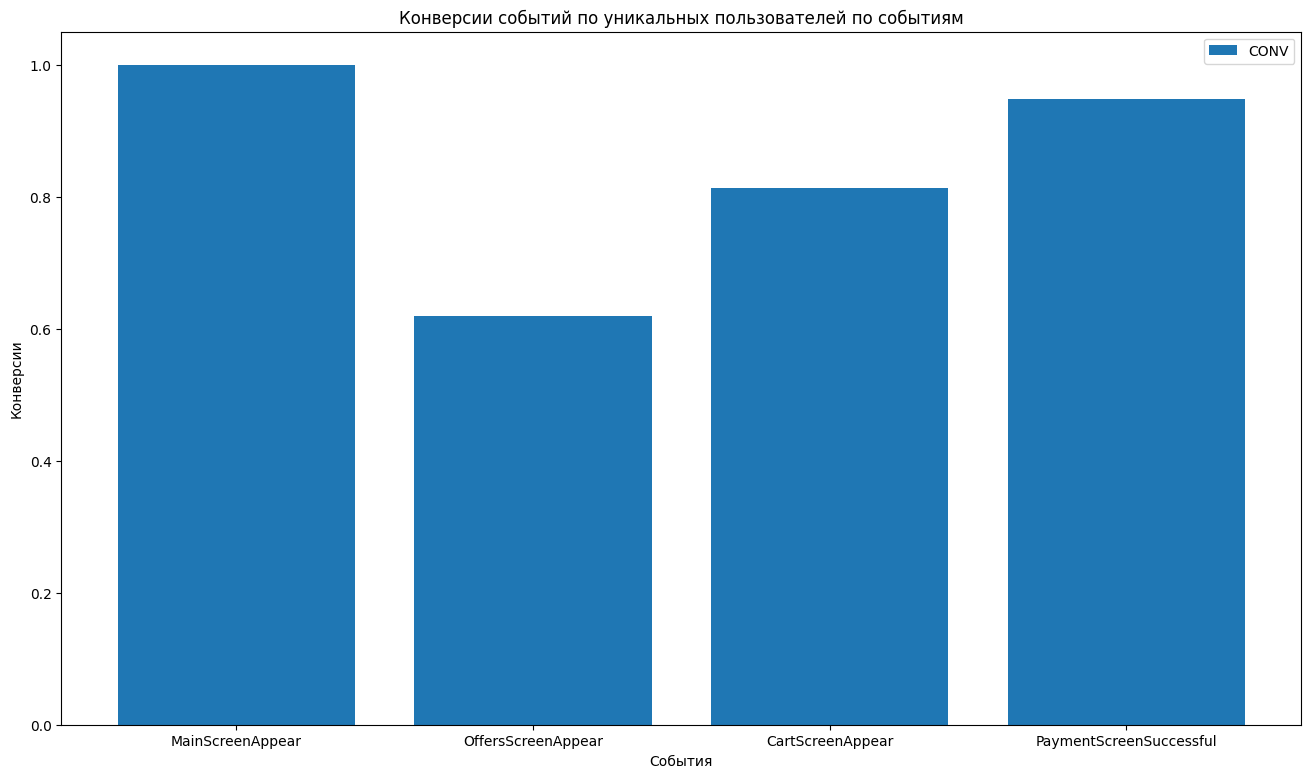

In [61]:
# Строим график для визуализации конверсий от шага к шагу по событиям по уникальным пользователям
plt.figure(figsize=(16, 9))
plt.bar(t1['event_name'], t1['ratio'],label='CONV')

# Оформляем графики
plt.title('Конверсии событий по уникальных пользователей по событиям')
plt.ylabel('Конверсии')
plt.xlabel('События')

plt.legend();

Больше всего теряется покупателей на переходе с главной страницы сайта (приложения) в каталог продуктов. 

Еще один важный показатель - доля купивших среди зашедших:

In [62]:
step_1_3 = df_groupe[df_groupe['event_name'] == 'PaymentScreenSuccessful']['count'][3] / df_groupe[df_groupe['event_name'] == 'MainScreenAppear']['count'][1]
print ('Доля прошедших весь путь  от MainScreenAppear до PaymentScreenSuccessful - ', round(step_1_3*100., 2), '%')

Доля прошедших весь путь  от MainScreenAppear до PaymentScreenSuccessful -  47.7 %


Почти половина посетителей становятся покупателями.

А больше всего теряется покупателей на первом шаге - чуть меньше 40% зайдя в магазин даже не взглянули на ассортимент!

### Выводы по разделу 3

В разделе 3 были выполнены следующие работы и получены результаты:

- Выявлены распределения пользователей по событиям;
- Выстроены последовательности событий. `MainScreenAppear-OffersScreenAppear-CartScreenAppear-PaymentScreenSuccessful`;
- отброшено незначимое для воронки событий событие `Tutorial`;
- построена воронка событий для пользователей приложения;
- оценена пошаговая конверсия перехода от события к событию;
- Вычислена общая конверсия посетителей в покупателей - 47,7%.   
    

## Изучение  результатов эксперимента

### Подсчет пользователей в эксперименте

После отброшенной недели эксперимента и невлияющего на воронку события - обращения пользователя к руководству (`Tutorial`) остались данные для статистических исследований:

In [63]:
print('После изучения и проверки данных осталось ', df.shape[0], 'записи в  DataFrame - событий.')

После изучения и проверки данных осталось  239882 записи в  DataFrame - событий.


Между контрольными группами они распределились следующим образом:

In [64]:
group_exp = (
    df
    .groupby('exp_id', as_index=False)
    .agg({'id': 'count'})
)
group_exp.columns = ['exp_id', 'count']
group_exp

,exp_id,count
0,246,78985
1,247,76684
2,248,84213


Сведем данные в таблицу `PIVOT` для удобства проведения статистического анализа:

In [65]:
# df.head() Для памяти

In [66]:
t_pivot = pd.pivot_table(df,
               index=["event_name"], columns=["exp_id"],  aggfunc={"event_ts": len, "id": lambda x: len(x.unique())})
t_pivot

event_ts                  id            
exp_id                       246    247    248   246   247   248
event_name                                                      
CartScreenAppear           14690  12434  15179  1266  1238  1230
MainScreenAppear           37676  39090  40562  2450  2476  2493
OffersScreenAppear         14767  15179  16387  1542  1520  1531
PaymentScreenSuccessful    11852   9981  12085  1200  1158  1181

Первые три столбца данных - это  сумарное количество событий распределенное по событиям и по группам. Вторые три столбца - это количество уникальных пользователей по событиям и группам.

извлекая из этой таблицы данные для статического анализа возможна проверка гипотез связанных со  сравнением пропорций двух совокупностей по выборкам из них.

Подготовим данные для проведения тестов. Так как сравнивать придется много, впоследствии будет разработана функция. Чтобы функция корректно работала, все данные должны быть представлены в едином формате.

Для начала подготовим данные для проведения А/А - теста между выборками 246 и 247

In [67]:
t_pivot = t_pivot.sort_values(by=('event_ts', 246), ascending=False) #сразу сортируем
t_pivot

event_ts                  id            
exp_id                       246    247    248   246   247   248
event_name                                                      
MainScreenAppear           37676  39090  40562  2450  2476  2493
OffersScreenAppear         14767  15179  16387  1542  1520  1531
CartScreenAppear           14690  12434  15179  1266  1238  1230
PaymentScreenSuccessful    11852   9981  12085  1200  1158  1181

In [68]:
t_pivot.columns # Посмотрим название колонок в переменной t_pivot - они сложные двухуровневые. Поэтому я не люблю pivot, а чаще пользуюсь группировкой

MultiIndex([('event_ts', 246),
            ('event_ts', 247),
            ('event_ts', 248),
            (      'id', 246),
            (      'id', 247),
            (      'id', 248)],
           names=[None, 'exp_id'])

In [69]:
df_a1_groupe = pd.DataFrame(t_pivot[(      'id', 246)]) # начинаем формировать табличку для данных 246й выборки
df_a1_groupe

,id
,246
event_name,
MainScreenAppear,2450
OffersScreenAppear,1542
CartScreenAppear,1266
PaymentScreenSuccessful,1200


In [70]:
df_a1_groupe = df_a1_groupe.reset_index() # индекс добавляем
df_a1_groupe

,event_name,id
,,246
0,MainScreenAppear,2450
1,OffersScreenAppear,1542
2,CartScreenAppear,1266
3,PaymentScreenSuccessful,1200


In [71]:
df_a1_groupe.columns = ['event_name', 'user_count'] # Переименовываем колонки
df_a1_groupe

,event_name,user_count
0,MainScreenAppear,2450
1,OffersScreenAppear,1542
2,CartScreenAppear,1266
3,PaymentScreenSuccessful,1200


In [72]:
df_a1_groupe['ratio'] = round (df_a1_groupe['user_count'] / df_a1_groupe['user_count'].shift(periods=1), 5)# Добавляем колонку
df_a1_groupe = df_a1_groupe.fillna(1.)# Заполняем конверсию первого шага 1.
df_a1_groupe

,event_name,user_count,ratio
0,MainScreenAppear,2450,1.00000
1,OffersScreenAppear,1542,0.62939
2,CartScreenAppear,1266,0.82101
3,PaymentScreenSuccessful,1200,0.94787


Данные для анализа выборки 246 готовы.
Пройдем аналогичный путь для 247:

In [73]:
df_a2_groupe = pd.DataFrame(t_pivot[(      'id', 247)])
df_a2_groupe = df_a2_groupe.reset_index() 
df_a2_groupe.columns = ['event_name', 'user_count']
df_a2_groupe['ratio'] = round (df_a2_groupe['user_count'] / df_a2_groupe['user_count'].shift(periods=1), 5)
df_a2_groupe = df_a2_groupe.fillna(1.)
df_a2_groupe

,event_name,user_count,ratio
0,MainScreenAppear,2476,1.00000
1,OffersScreenAppear,1520,0.61389
2,CartScreenAppear,1238,0.81447
3,PaymentScreenSuccessful,1158,0.93538


***Данные подготовлены, можно двигаться дальше.***

### Проверка статистическими критериями разницы между выборками  246 и 247

Решим задачу сравнения пропорций двух генеральных совокупностей по выборкам из них.\
Есть 2е выборки - `df_a1 (246)` и `df_a2 (247)`\
Разница между пропорциями, наблюдаемыми на выборках, будет нашей статистикой.

Выдвенем нулевую гипотезу, что выборки `df_a1 (246)` и `df_a2 (247)` - ***ОДИНАКОВЫЕ***

**Н0** : Выборки одинаковые\
**Н1** : Выборки разные

Впоследствии произведем расчет пропорций для двух контрольных выборок, экспериментальной и общей: 

In [74]:
df_b_groupe = pd.DataFrame(t_pivot[(      'id', 248)])
df_b_groupe = df_b_groupe.reset_index() 
df_b_groupe.columns = ['event_name', 'user_count']
df_b_groupe['ratio'] = round (df_b_groupe['user_count'] / df_b_groupe['user_count'].shift(periods=1), 5)
df_b_groupe = df_b_groupe.fillna(1.)
df_b_groupe

,event_name,user_count,ratio
0,MainScreenAppear,2493,1.00000
1,OffersScreenAppear,1531,0.61412
2,CartScreenAppear,1230,0.80340
3,PaymentScreenSuccessful,1181,0.96016


Все три выборки готовы и сведены в аналогичные переменные.

Сравним доли клиентов, сделавших 1й шаг на пути к покупке в магазине - событие `OffersScreenAppear` между контрольными группами.

Для сравнения нам понадобиться генеральная выборка и аналогичные пропорции: генеральную выборку можно сделать с помощью групировки.

In [75]:
df_groupe = df.groupby(['event_name','id'])['event_ts'].count().reset_index()
df_groupe = df_groupe.groupby(['event_name'])['event_ts'].count().reset_index()
df_groupe = df_groupe.sort_values(by='event_ts', ascending=False).reset_index()

df_groupe = df_groupe.drop('index', axis=1)

df_groupe.columns = ['event_name', 'user_count']

df_groupe['ratio'] = round (df_groupe['user_count'] / df_groupe['user_count'].shift(periods=1), 5)
df_groupe = df_groupe.fillna(1.)
df_groupe

,event_name,user_count,ratio
0,MainScreenAppear,7419,1.00000
1,OffersScreenAppear,4593,0.61909
2,CartScreenAppear,3734,0.81298
3,PaymentScreenSuccessful,3539,0.94778


#### Статистическая проверка

Сравним доли клиентов, сделавших 2й шаг на пути к покупке в магазине - событие `OffersScreenAppear`.

Для памяти перенесем сводные таблицы:

In [76]:
df_a1_groupe

,event_name,user_count,ratio
0,MainScreenAppear,2450,1.00000
1,OffersScreenAppear,1542,0.62939
2,CartScreenAppear,1266,0.82101
3,PaymentScreenSuccessful,1200,0.94787


In [77]:
df_a2_groupe

,event_name,user_count,ratio
0,MainScreenAppear,2476,1.00000
1,OffersScreenAppear,1520,0.61389
2,CartScreenAppear,1238,0.81447
3,PaymentScreenSuccessful,1158,0.93538


Воспользуемся формулами для сравнения долей:

Разница между пропорциями, наблюдаемыми на выборках, будет нашей статистикой. Так называется переменная, значения которой рассчитываются только по выборочным данным. Можно доказать, что она распределена нормально:

В формуле n₁ и n₂ — размеры двух сравниваемых выборок, то есть количества наблюдений в них; P₁, P₂ — пропорции, наблюдаемые в выборках; P — пропорция в выборке, скомбинированной из двух наблюдаемых; π₁, π₂ — настоящие пропорции в сравниваемых генеральных совокупностях.

В A/B-тестировании чаще всего проверяют гипотезу о равенстве π₁ и π₂. Тогда при верной нулевой гипотезе выражение (π₁ - π₂) в числителе будет равно нулю, и критерий можно рассчитывать только по выборочным данным.
Поскольку полученная статистика будет распределена нормально, так можно проводить двусторонние и односторонние тесты. При той же нулевой гипотезе о равенстве пропорций двух генеральных совокупностей можно проверить альтернативные гипотезы о том, что 1) они просто неравны, или 2) одна пропорция больше или меньше другой.


In [78]:
alpha = 0.05
successes = np.array([df_a1_groupe['user_count'][2], df_a2_groupe['user_count'][2]])
successes

trials = np.array([df_a1_groupe['user_count'][1], df_a2_groupe['user_count'][1]])
trials

p1 = df_a1_groupe['ratio'][2]
p2 = df_a2_groupe['ratio'][2]
p1, p2

difference = p1 - p2

p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

In [79]:
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = stats.norm(0, 1)


Если бы пропорции были равны, разница между ними была бы равна нулю. Посчитаем, как далеко статистика уехала от нуля. Какова вероятность получить такое отличие или больше? Так как распределение статистики нормальное, вызовем метод `cdf()`. Саму статистику возьмём по модулю методом `abs()` — чтобы получить правильный результат независимо от её знака. Это возможно, потому что тест двусторонний. По этой же причине удваиваем результат:

In [80]:
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 


p-значение:  0.6392724313624212
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка статистическими критериями разницы между выборками 246 и 247 в разрезе пользователей по критерию сравнения пропорций перехода с главной страницы в каталог товаров прошла удачно, нулевая гипотеза подтверждена - между долями нет значимой разницы.

Логика проверки понятна, самое время проверить каждое событие на всем DataFrame

#### Подготовка А/А - эксперимента

Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп:

Для начала посмотрим, как часто пользователи "генерировали" события - проверим нехарактерные и завышенные активности пользователей с целью до проведения эксперимента отбросить нехарактерных пользователей.

In [81]:
df_gr = df.groupby(['event_name','id','exp_id'])['event_ts'].count().reset_index()
print (df_gr)

                    event_name                   id  exp_id  event_ts
0             CartScreenAppear     6909561520679493     247         1
1             CartScreenAppear     6922444491712477     246         8
2             CartScreenAppear     7702139951469979     247         5
3             CartScreenAppear     8486814028069281     248         4
4             CartScreenAppear     9841258664663090     248         8
...                        ...                  ...     ...       ...
19280  PaymentScreenSuccessful  9212961170535635779     246         3
19281  PaymentScreenSuccessful  9214668690707156694     248         9
19282  PaymentScreenSuccessful  9216369613838971606     246         1
19283  PaymentScreenSuccessful  9217594193087726423     246         3
19284  PaymentScreenSuccessful  9219463515465815368     248         1

[19285 rows x 4 columns]


count    19285.000000
mean        12.438787
std         26.344292
min          1.000000
25%          3.000000
50%          7.000000
75%         14.000000
max       1100.000000
Name: event_ts, dtype: float64

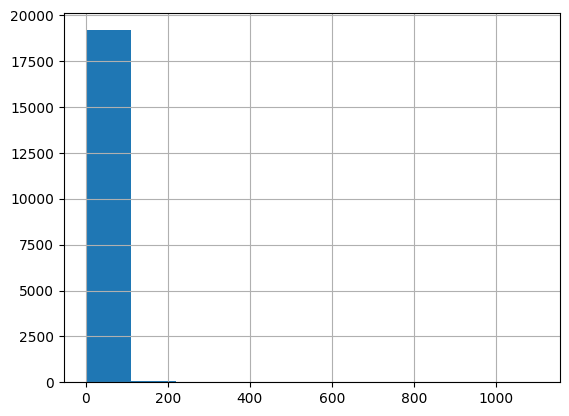

In [82]:
#Посмотрим нет ли пользователей с нехарактерными количествами событий.
df_gr['event_ts'].unique()
#Посмотрим частотное распределение на гистограмме 
df_gr['event_ts'].hist()
df_gr['event_ts'].describe()

На графике (гистограмме) хорошо видно, что каждый из пользователей основного массивы данных совершил в среднем до 50 событий. 
Свыше 50 событий за неделю будем считать нехарактерными и отбросим.

In [83]:

df_gr = df_gr.query('event_ts < 50')
df_gr


,event_name,id,exp_id,event_ts
0,CartScreenAppear,6909561520679493,247,1
1,CartScreenAppear,6922444491712477,246,8
2,CartScreenAppear,7702139951469979,247,5
3,CartScreenAppear,8486814028069281,248,4
4,CartScreenAppear,9841258664663090,248,8
...,...,...,...,...
19280,PaymentScreenSuccessful,9212961170535635779,246,3
19281,PaymentScreenSuccessful,9214668690707156694,248,9
19282,PaymentScreenSuccessful,9216369613838971606,246,1
19283,PaymentScreenSuccessful,9217594193087726423,246,3


Итак, в этом параграфе учебного проекта считаем уникальных пользователей.

Количество событий у каждого пользователя внутри группы отражено в столбце `event_ts`.

Получим сводную таблицу для всех оставшихся данных:

In [84]:
df_gr_temp_t = df_gr
df_gr_temp_t = df_gr.groupby(['event_name'])['event_ts'].count().reset_index()
df_gr_temp_t = df_gr_temp_t.sort_values(by='event_ts', ascending=False).reset_index() 
df_gr_temp_t = df_gr_temp_t.drop('index', axis=1)
df_gr_temp_t.columns = ['event_name', 'user_count']
df_gr_temp_t['ratio'] = round (df_gr_temp_t['user_count'] / df_gr_temp_t['user_count'].shift(periods=1), 5)
df_gr_temp_t = df_gr_temp_t.fillna(1.)
df_gr_temp_t

,event_name,user_count,ratio
0,MainScreenAppear,7128,1.00000
1,OffersScreenAppear,4499,0.63117
2,CartScreenAppear,3641,0.80929
3,PaymentScreenSuccessful,3468,0.95249


А теперь для каждой экспериментальной группы:

In [85]:
df_gr_temp_a1 = df_gr.query('exp_id == 246')
df_gr_temp_a1 = df_gr_temp_a1.groupby(['event_name'])['event_ts'].count().reset_index()
df_gr_temp_a1.groupby(['event_name'])['event_ts'].sum().reset_index()
df_gr_temp_a1 = df_gr_temp_a1.sort_values(by='event_ts', ascending=False).reset_index() 
df_gr_temp_a1 = df_gr_temp_a1.drop('index', axis=1)
df_gr_temp_a1.columns = ['event_name', 'user_count']
df_gr_temp_a1['ratio'] = round (df_gr_temp_a1['user_count'] / df_gr_temp_a1['user_count'].shift(periods=1), 5)
df_gr_temp_a1 = df_gr_temp_a1.fillna(1.)
df_gr_temp_a1

,event_name,user_count,ratio
0,MainScreenAppear,2368,1.00000
1,OffersScreenAppear,1517,0.64062
2,CartScreenAppear,1230,0.81081
3,PaymentScreenSuccessful,1175,0.95528


In [86]:
df_gr_temp_a2 = df_gr.query('exp_id == 247')
df_gr_temp_a2 = df_gr_temp_a2.groupby(['event_name'])['event_ts'].count().reset_index()
df_gr_temp_a2.groupby(['event_name'])['event_ts'].sum().reset_index()
df_gr_temp_a2 = df_gr_temp_a2.sort_values(by='event_ts', ascending=False).reset_index() 
df_gr_temp_a2 = df_gr_temp_a2.drop('index', axis=1)
df_gr_temp_a2.columns = ['event_name', 'user_count']
df_gr_temp_a2['ratio'] = round (df_gr_temp_a2['user_count'] / df_gr_temp_a2['user_count'].shift(periods=1), 5)
df_gr_temp_a2 = df_gr_temp_a2.fillna(1.)
df_gr_temp_a2

,event_name,user_count,ratio
0,MainScreenAppear,2374,1.00000
1,OffersScreenAppear,1491,0.62805
2,CartScreenAppear,1210,0.81154
3,PaymentScreenSuccessful,1135,0.93802


In [87]:
df_gr_temp_b = df_gr.query('exp_id == 248')
df_gr_temp_b = df_gr_temp_b.groupby(['event_name'])['event_ts'].count().reset_index()
df_gr_temp_b.groupby(['event_name'])['event_ts'].sum().reset_index()
df_gr_temp_b = df_gr_temp_b.sort_values(by='event_ts', ascending=False).reset_index() 
df_gr_temp_b = df_gr_temp_b.drop('index', axis=1)
df_gr_temp_b.columns = ['event_name', 'user_count']
df_gr_temp_b['ratio'] = round (df_gr_temp_b['user_count'] / df_gr_temp_b['user_count'].shift(periods=1), 5)
df_gr_temp_b = df_gr_temp_b.fillna(1.)
df_gr_temp_b

,event_name,user_count,ratio
0,MainScreenAppear,2386,1.0000
1,OffersScreenAppear,1491,0.6249
2,CartScreenAppear,1201,0.8055
3,PaymentScreenSuccessful,1158,0.9642


По аналогии с проверкой проведенной в пункте 4.2 проведем проверку между пропорциями в переменной `df_gr_temp_a1 = df_gr.query('exp_id == 246')`, где собраны данные по первой конторольной группе и `df_gr_temp_a2 = df_gr.query('exp_id == 247')`, где собраны данные по второй контрольной группе.

In [88]:
display (df_gr_temp_a1)# для памяти
display (df_gr_temp_a2)

,event_name,user_count,ratio
0,MainScreenAppear,2368,1.00000
1,OffersScreenAppear,1517,0.64062
2,CartScreenAppear,1230,0.81081
3,PaymentScreenSuccessful,1175,0.95528


,event_name,user_count,ratio
0,MainScreenAppear,2374,1.00000
1,OffersScreenAppear,1491,0.62805
2,CartScreenAppear,1210,0.81154
3,PaymentScreenSuccessful,1135,0.93802


In [89]:
df1 = df_gr_temp_a1 # будем работать с короткими названиями, так как в последствии будем изобретать функцию
df2 = df_gr_temp_a2
dfb = df_gr_temp_b

Те же данные получаем из файлов, за исключением `p_combined` получить из переменной `df_groupe`, на каждом шаге проверяем!

Данные готовы. Выдвенем нулевую гипотезу, что выборки df1 (246) и df2 (247), очищенные от нехарактерных посетителей - ***ОДИНАКОВЫЕ***

***Н0*** : Выборки одинаковые\
***Н1*** : Выборки разные

Произведем расчет пропорций для двух контрольных выборок

In [90]:
p1 = df1['ratio'][1]
p2 = df2['ratio'][1]
p_combined = dfb['ratio'][1]
successes = np.array([df1['user_count'][1], df2['user_count'][1]])
trials = np.array([df1['user_count'][1-1], df2['user_count'][1-1]])

In [91]:
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = stats.norm(0, 1)

In [92]:
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница в событии ', df2['event_name'][1])
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в событии ', df2['event_name'][1]
    ) 


p-значение:  0.6418575101268185
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в событии  OffersScreenAppear


И для "очищенных" данных  отвергнуть нулевую гипотезу не удалось - на основании равенства пропорций выборки с очищенными данными показывают одинаковые доли в событии OffersScreenAppear.

#### Создание функции compare_shares

Так как нам нужно расчитывать эти параметры для разных данных, для разных событий разумнее будет завернуть расчеты в функцию, пердавя в качестве аргументов сводные таблицы по событиям. В функцию передаем две сравниваемые переменные и номер события, также передаем критический уровень статистической значимости - по умолчанию 0,05

In [93]:
# функция для проверки гипотезы равности долей при переходе от события к событию

def compare_shares(df1, df2, i, alpha = .05):

    # критический уровень статистической значимости передаем из вне  или по умолчанию
    #alpha = .05 # критический уровень статистической значимости

    successes = np.array([df1['user_count'][i], df2['user_count'][i]]) #успехи, в нашем случае количество клиентов совершивших событие df2['event_name'][i] в группах А1 и А2 соответственно
    trials = trials = np.array([df1['user_count'][i-1], df2['user_count'][i-1]])    #испытания, в нашем случае количество клиентов на предыдущем шаге df2['event_name'][i-1] в группах А1 и А2 соответственно


    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница в событии ', df2['event_name'][i])
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в событии ', df2['event_name'][i]
    ) 
    return

Функция compare_shares получилась. Получая на входе две таблицы, номер прпорции в виде строки таблицы, и альфа - критический уровень статистической значимости функция сразу выдает заключение о значимой разнице между долями выборок.

#### Исследования с помощью функции compare_shares

Если завернуть эту функцию в цикл, то можно сразу "пробежаться" по всем событиям:

Подставляем переменные из параграфа 4.2. для двух контрольных выборок без отфильтрования нехарактерных пользователей совершивших более 50 событий за рассматриваемый период.

Выдвигаем нулевую гипотезу, что выборки `df_a1_groupe (246)` и `df_a2_groupe (247)` - ***ОДИНАКОВЫЕ***

**Н0** : Выборки одинаковые\
**Н1** : Выборки разные


In [94]:
# сводные таблицы df_a1_groupe, df_a2_groupe
for i in [1, 2, 3]:
    compare_shares(df_a1_groupe, df_a2_groupe, i, alpha = .05)

p-значение:  0.2622344959255778
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в событии  OffersScreenAppear
p-значение:  0.6393754713145263
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в событии  CartScreenAppear
p-значение:  0.18243439408067652
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в событии  PaymentScreenSuccessful


Внутри этих выборок мы имеем 3 перехода от события к событию. Во всех трех доли между выборками получились одинаковыми. Оставляем нулевую гипотезу - Выборки df_a1_groupe, df_a2_groupe - ОДИНАКОВЫ!

Но мы не останавливаемся, есть возможность еще проверить, ведь сейчас с функцией это так легко. Проверим таблицы `df_gr_temp_a1` и `df_gr_temp_a2` с убранными не типичными значениями.

Выдвигаем еще одну нулевую гипотезу, что выборки `df_gr_temp_a1 (246)` и `df_gr_temp_a1 (247)` - ***ОДИНАКОВЫЕ***

**Н0** : Выборки одинаковые\
**Н1** : Выборки разные


In [95]:
for i in [1, 2, 3]:
    compare_shares(df_gr_temp_a1, df_gr_temp_a2, i, alpha = .05)

p-значение:  0.3688053595638414
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в событии  OffersScreenAppear
p-значение:  0.9594831796530223
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в событии  CartScreenAppear
p-значение:  0.05757588024184668
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в событии  PaymentScreenSuccessful


Доработанные тестовые выборки с отвергнутыми нетипичными значениями тоже показали, что нет оснований считать доли разными на всех событиях. Выборки `df_gr_temp_a1` и `df_gr_temp_a2` - ***ОДИНАКОВЫ***!

Принимаю решение:

- по результатам А/А - теста проведенного без отбрасывания нетипичных покупателей считать выборки `df_a1_groupe`, `df_a2_groupe` одинаковыми;
- по результатам А/А - теста проведенного с фильтрацией нетипичных покупателей считать выборки `df_a1_groupe`, `df_a2_groupe` одинаковыми;
- А/В - тест проводить на выборках `df_a1_groupe` и `df_gr_temp_a1`

Перед проведением А/В - теста формулируем нулевую гипотезу:

Выборки `df_a1_groupe` (246) и `df_b_groupe` (248) - ***ОДИНАКОВЫЕ***

***Н0*** : Выборки одинаковые\
***Н1*** : Выборки разные

Произведем расчет пропорций для контрольной выборки и экспериментальной:

In [96]:
for i in [1, 2, 3]:
    compare_shares(df_a1_groupe, df_b_groupe, i, alpha = .05)

p-значение:  0.2684281587249231
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в событии  OffersScreenAppear
p-значение:  0.2112170818054686
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в событии  CartScreenAppear
p-значение:  0.14295341270419004
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в событии  PaymentScreenSuccessful


Проверка теста показывает, что пропорции между первой конторольной и экспериментальной выборками не отличаются для данных с нетипичными пользователями. Проверим пропорции между контрольной и экспериментальными выборками с отброшенными нетипичными пользователями, "сгенерировшими" более 50 событий - `df_gr_temp_a1`, `df_gr_temp_b`

Формулируем нулевую гипотезу: Выборки `df_gr_temp_a1` (246) и `df_gr_temp_a1` (248) - ***ОДИНАКОВЫЕ***

***Н0*** : Выборки одинаковые\
***Н1*** : Выборки разные

In [97]:
for i in [1, 2, 3]:
    compare_shares(df_gr_temp_a1, df_gr_temp_b, i, alpha = .05)

p-значение:  0.2606277953155529
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в событии  OffersScreenAppear
p-значение:  0.7114607689073307
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в событии  CartScreenAppear
p-значение:  0.2640320420904798
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в событии  PaymentScreenSuccessful


На этих данных пропорции показывают, что разницы в данных `df_gr_temp_a1`, `df_gr_temp_b` нет.
`
попробуем сравнить доли у суммарной контрольной группы с экспериментальной. Данные получим их сводной таблицы, которую подготовим из `df`:

In [98]:
t_pivot = pd.pivot_table(df,
               index=["event_name"], columns=["exp_id"],  aggfunc={"event_ts": len, "id": lambda x: len(x.unique())})
t_pivot

event_ts                  id            
exp_id                       246    247    248   246   247   248
event_name                                                      
CartScreenAppear           14690  12434  15179  1266  1238  1230
MainScreenAppear           37676  39090  40562  2450  2476  2493
OffersScreenAppear         14767  15179  16387  1542  1520  1531
PaymentScreenSuccessful    11852   9981  12085  1200  1158  1181

In [99]:
t_pivot.columns

MultiIndex([('event_ts', 246),
            ('event_ts', 247),
            ('event_ts', 248),
            (      'id', 246),
            (      'id', 247),
            (      'id', 248)],
           names=[None, 'exp_id'])

In [100]:
t_pivot = t_pivot.sort_values(by=('event_ts', 246), ascending=False)

Дополняем сводную таблицу столбцом суммой количества пользователей в двух контрольных группах:

In [101]:
t_pivot [('id', 'a0')] = t_pivot [('id', 246)] + t_pivot [('id', 247)]
t_pivot

event_ts                  id                  
exp_id                       246    247    248   246   247   248    a0
event_name                                                            
MainScreenAppear           37676  39090  40562  2450  2476  2493  4926
OffersScreenAppear         14767  15179  16387  1542  1520  1531  3062
CartScreenAppear           14690  12434  15179  1266  1238  1230  2504
PaymentScreenSuccessful    11852   9981  12085  1200  1158  1181  2358

In [102]:
t_pivot.index

Index(['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear',
       'PaymentScreenSuccessful'],
      dtype='object', name='event_name')

In [103]:
t_pivot.columns

MultiIndex([('event_ts',  246),
            ('event_ts',  247),
            ('event_ts',  248),
            (      'id',  246),
            (      'id',  247),
            (      'id',  248),
            (      'id', 'a0')],
           names=[None, 'exp_id'])

In [104]:
t_pivot[(      'id', 'a0')]

event_name
MainScreenAppear           4926
OffersScreenAppear         3062
CartScreenAppear           2504
PaymentScreenSuccessful    2358
Name: (id, a0), dtype: int64

In [105]:
df_b_groupe

,event_name,user_count,ratio
0,MainScreenAppear,2493,1.00000
1,OffersScreenAppear,1531,0.61412
2,CartScreenAppear,1230,0.80340
3,PaymentScreenSuccessful,1181,0.96016


Соберем таблицу для использования в функции compare_shares

In [106]:
df_a0_groupe = pd.DataFrame(t_pivot[(      'id', 'a0')])
df_a0_groupe = df_a0_groupe.reset_index() 
df_a0_groupe.columns = ['event_name', 'user_count']
df_a0_groupe['ratio'] = round (df_a0_groupe['user_count'] / df_a0_groupe['user_count'].shift(periods=1), 5)
df_a0_groupe = df_a0_groupe.fillna(1.)
df_a0_groupe

,event_name,user_count,ratio
0,MainScreenAppear,4926,1.00000
1,OffersScreenAppear,3062,0.62160
2,CartScreenAppear,2504,0.81777
3,PaymentScreenSuccessful,2358,0.94169


In [107]:
for i in [1, 2, 3]:
    compare_shares(df_a0_groupe, df_b_groupe, i, alpha = .05)

p-значение:  0.5308589432077624
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в событии  OffersScreenAppear
p-значение:  0.23905954279947372
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в событии  CartScreenAppear
p-значение:  0.017114434319547067
Отвергаем нулевую гипотезу: между долями есть значимая разница в событии  PaymentScreenSuccessful


Значимая разница между долями объединенной контрольной группы и экспериментальной наблюдается лишт в событии `PaymentScreenSuccessful`

#### Принятие решения о использовании нового шрифта

Предыдущей части мы выяснили, что пропорции в масивах данных между контрольной общей группой `df_a0_groupe`, которой демонстрировался сайт магазина со старым шрифтом и группой df_b_groupe, которой демонстрировался сайт с новым шрифтом ***ОТЛИЧАЮТСЯ*** в событии  `PaymentScreenSuccessful`.

Необходимо выяснить, на каком шрифте клиенты демонстрируют лучшую конверсию. Посмотрим на графике.


In [108]:
t = df_a0_groupe # для графика
t['ratio_b'] = df_b_groupe['ratio']
t['ratio_a'] = t['ratio'] 
t

,event_name,user_count,ratio,ratio_b,ratio_a
0,MainScreenAppear,4926,1.00000,1.00000,1.00000
1,OffersScreenAppear,3062,0.62160,0.61412,0.62160
2,CartScreenAppear,2504,0.81777,0.80340,0.81777
3,PaymentScreenSuccessful,2358,0.94169,0.96016,0.94169


Лучше всего это сделать визуально на графике:

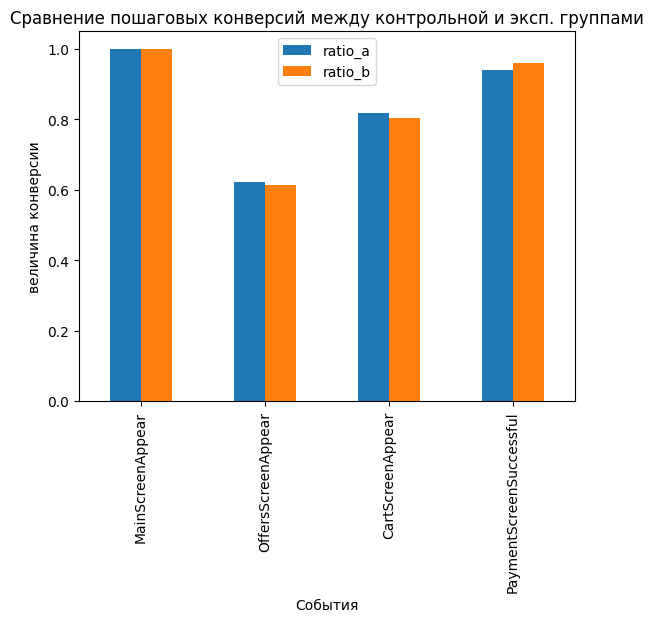

In [109]:
t.plot(x="event_name", y=["ratio_a", "ratio_b"], kind='bar')

# Строим график для визуализации конверсии событий экспериментальной группы

# Оформляем графики
plt.title('Сравнение пошаговых конверсий между контрольной и эксп. группами')
plt.xlabel('События')
plt.ylabel('величина конверсии', rotation=90);
plt.legend();

На графике хорошо видно, что экспериментальная группа, которой показвался сайт с обновленным шрифтом показывает меньшие конверсии (переходы на следуюший экран на пути к оплате покупки) по сравнению с группой, которой показывался сайт с обычным шрифтом. Лишь на последнем переходе в успешную оплату (событие PaymentScreenSuccessful) эксперементальная группа показывает результат несколько больший, чем объединенная контрольная группа.

Для подтвержения сказанного можно продемонстрировать две цифры:

- конверсия из посетителей в покупателей для сайта со старым шрифтом;
- конверсия из посетителей в покупателей для обновленного сайта с новым шрифтом

In [110]:
print ('Конверсия из посетителей в покупателей для сайта со старым шрифтом            ', df_a0_groupe['user_count'][3]/df_a0_groupe['user_count'][0])

Конверсия из посетителей в покупателей для сайта со старым шрифтом             0.47868453105968334


In [111]:
print ('Конверсия из посетителей в покупателей для обновленного сайта с новым шрифтом',df_b_groupe['user_count'][3]/df_b_groupe['user_count'][0])

Конверсия из посетителей в покупателей для обновленного сайта с новым шрифтом 0.47372643401524267


В общей конверсии разница в десятых долях процента - незначительна.

#### Вывод по разделу 4

По результатам проведенных в рамках учебного проекта расчетов можно рекомендовать не менять шрифт, так как на старых шрифтах пошаговая конверсия от события к событию и общая конверся посетителей в покупатели практически не изменилась.

В рамках выполнения раздела 4 выполненны следующие работы и получены результаты:

- подсчитано количество событий и пользователей участвующих в проведении А/А/В - экспериментов. Количество событий оставшихся после очиски - 240887, количество пользователей "сгенерировавших" эти события - 7534;
- Пользователи разделены на три группы по эксперименту
        контрольная группа 1 - 79302 событий, 2513 пользователей 
        контрольная группа 2 - 77022 события, 2537 пользователей
        экспериментальная группа - 84563 события, 2537 пользователей
        
- Проведена предварительная проверка статистическими критериями между контрольными выборками, которая показала, что между долями выборок нет существенной разницы;
- Разработана и проверена на работоспособность функция compare_shares для автоматизации проверки долей выборок в части проверки гипотез о равенстве долей;
- Отвергнуто соображение о необходимости исключения из выборок пользователей совершивших более 50 событий;
- С помощью функции compare_shares проведены проверки А/А и А/В - теста для улучшения вида приложения путем изменения шрифта.


## Общие выводы по учебному проекту

В процессе работы над учебным проектом решены поставленные задачи и сформулированы выводы по разделам:

- Загружены и подготовлены данные из файла logs_exp.csv;
- Подготовлены данные для дальнейшей работы;
- Изучены и прверены данные;
- Изучена и проверена воронка событий, отброшено событие, которое не участвует в перемещении посетителя к покупке товаров в приложении;
- Изучены результаты А/А/В - эксперимента и даны рекомендации:


***По результатам проведенных в рамках учебного проекта расчетов можно рекомендовать не менять шрифт, так как не наблюдается изменение конверсии, на новых шрифтах пошаговая конверсия от события к событию и общая конверсия посетителей в покупатели не меняется.***



In [112]:
2+2

4